<a href="https://colab.research.google.com/github/angelacantutrevino/Seq2Seq-Translation/blob/main/Seq2Seq_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transforming Natural Language into SQL Queries**

### **Libraries**

In [1]:
# Loading Data and Pre-Processing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Tensor Flow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
# Keras
from keras import layers, models
from keras.layers import GRU, Input, Dense, TimeDistributed, RepeatVector
from keras.models import Model, Sequential
from keras.losses import sparse_categorical_crossentropy
from keras.utils.vis_utils import plot_model

### **Importing Data**

In [2]:
import pandas as pd

df = pd.read_json('train_spider.json')

In [3]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


In [4]:
df.dtypes

db_id                  object
query                  object
query_toks             object
query_toks_no_value    object
question               object
question_toks          object
sql                    object
dtype: object

In [5]:
df.columns

Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')

In [6]:
df.isnull().values.any()

False

In [7]:
df.shape

(7000, 7)

### **Preparing Data**

Since, we have a very large database we choose to examine only the first 1000 instances for a simpler and more efficient analysis.

In [8]:
df_new = df.iloc[:1000,:]

In [9]:
df_new.head

<bound method NDFrame.head of                      db_id                                              query  \
0    department_management         SELECT count(*) FROM head WHERE age  >  56   
1    department_management  SELECT name ,  born_state ,  age FROM head ORD...   
2    department_management  SELECT creation ,  name ,  budget_in_billions ...   
3    department_management  SELECT max(budget_in_billions) ,  min(budget_i...   
4    department_management  SELECT avg(num_employees) FROM department WHER...   
..                     ...                                                ...   
995  university_basketball  SELECT avg(enrollment) FROM university WHERE f...   
996  university_basketball  SELECT avg(enrollment) FROM university WHERE f...   
997  university_basketball  SELECT enrollment ,  primary_conference FROM u...   
998  university_basketball  SELECT enrollment ,  primary_conference FROM u...   
999  university_basketball  SELECT sum(enrollment) ,  min(enrollment) FROM...  

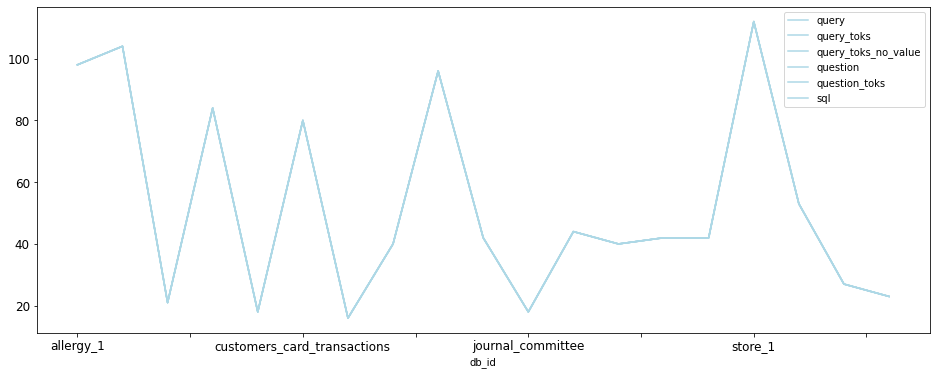

In [10]:
df_new.groupby(['db_id']).count().plot(fontsize = 12, color ='lightblue', figsize = (16,6))

In [11]:
input_data = df_new['question']
target_data = df_new['query'] 

### **Pre-Processing**

In [12]:
# Tokenization
def tokenization(input_data):
  x_token = Tokenizer()
  x_token.fit_on_texts(input_data)
  return x_token.texts_to_sequences(input_data), x_token

x, x_token = tokenization(input_data)
y, y_token = tokenization(target_data)

In [13]:
# Padding
def padding(input_data, length=None):
  if length is None:
    length = max([len(sentence) for sentence in input_data])
  return pad_sequences(input_data, maxlen=length, padding='post', truncating='post')

x = padding(x)
y = padding(y)

In [14]:
 # Reshape label because the keras's sparse_categorical_crossentropy function used later requires it to be in 3D
 y = y.reshape(*y.shape, 1)

In [15]:
# Find maximum sentence lengths for both questions and queries and its size to later use in model. 

x_max_sentence_length = x.shape[1]
y_max_sentence_length = y.shape[1]

x_vocabulary_size = len(x_token.word_index)
y_vocabulary_size = len(y_token.word_index)

print(x_max_sentence_length)
print(y_max_sentence_length)
print(x_vocabulary_size)
print(y_vocabulary_size)

26
81
914
541


In [16]:
# Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% train, 30% test

In [17]:
# Reshape once again to be able to use in network. 
input_shape = padding(x_train, y_max_sentence_length)
input_shape = input_shape.reshape((-1, y_train.shape[-2], 1))

### **Encoder-Decoder Model**

In [18]:
def encoder_decoder(x_shape, y_max_sentence_length, x_vocabulary_size, y_vocabulary_size):
  
  model = Sequential()
  
  # Encoder
  encoder_input = Input(shape=x_shape[1:])
  encoder_gru = GRU(y_max_sentence_length)(encoder_input)
  encoder_output = Dense(128, activation='relu')(encoder_gru) 
 
  # Decoder
  decoder_input = RepeatVector(y_max_sentence_length)(encoder_output)
  decoder_gru = GRU(128, return_sequences=True)(decoder_input)
  layer = TimeDistributed(Dense(x_vocabulary_size, activation='softmax'))
  decoder_output = layer(decoder_gru)
 
  # Model 
  model = Model(inputs=encoder_input, outputs=decoder_output)
  model.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
  return model

### **Results**

In [19]:
encoder_decoder = encoder_decoder(input_shape.shape, y_max_sentence_length, x_vocabulary_size, y_vocabulary_size)
encoder_decoder.summary()

encoder_decoder_history = encoder_decoder.fit(input_shape, y_train, batch_size=25, epochs=10, validation_split=0.2)
print("Average training accuracy: ", np.average(encoder_decoder_history.history['accuracy']))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 81, 1)]           0         
                                                                 
 gru (GRU)                   (None, 81)                20412     
                                                                 
 dense (Dense)               (None, 128)               10496     
                                                                 
 repeat_vector (RepeatVector  (None, 81, 128)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 81, 128)           99072     
                                                                 
 time_distributed (TimeDistr  (None, 81, 914)          117906    
 ibuted)                                                     

In [ ]:
translation = {value: key for key, value in y_token.word_index.items()}

question = 'how many heads of the departments are older than 56'
question = [x_token.word_index[word] for word in question.split()]
question = pad_sequences([question], maxlen=x_train.shape[-1], padding='post')
queries = np.array([question[0], x_train[0]])
predictions = encoder_decoder.predict(queries, len(queries))

In [20]:
for i in range(10):
  print('Questions {}:  {}'.format(i + 1, input_data[i]))
  print('SQL query {}:  {}'.format(i + 1, target_data[i]))

Questions 1:  How many heads of the departments are older than 56 ?
SQL query 1:  SELECT count(*) FROM head WHERE age  >  56
Questions 2:  List the name, born state and age of the heads of departments ordered by age.
SQL query 2:  SELECT name ,  born_state ,  age FROM head ORDER BY age
Questions 3:  List the creation year, name and budget of each department.
SQL query 3:  SELECT creation ,  name ,  budget_in_billions FROM department
Questions 4:  What are the maximum and minimum budget of the departments?
SQL query 4:  SELECT max(budget_in_billions) ,  min(budget_in_billions) FROM department
Questions 5:  What is the average number of employees of the departments whose rank is between 10 and 15?
SQL query 5:  SELECT avg(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15
Questions 6:  What are the names of the heads who are born outside the California state?
SQL query 6:  SELECT name FROM head WHERE born_state != 'California'
Questions 7:  What are the distinct creation year